In [12]:
#IMPORTING SETUP PACKAGES
import statsmodels.formula.api as smf
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)

In [13]:
df = pd.read_pickle('/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/Top100_seller_YTD_group_by_item_visit.pickle')


In [15]:
df



,min_date,max_date,item_code,item_price,delivery_weeks,avg_sales,avg_unique_views,conv_rate,bin,item_parent_item_code,item_main_category,item_sub_category_1,item_sub_category_2,log_price,log_delivery_weeks,log_sales,log_avg_unique_views,log_conv_rate
0,2020-01-01,2020-01-07,000000001000054998,749.99,2,1.428571,72.857143,0.019608,7,000000008000006211,POLSTER,ECKSOFAS,LONGCHAIR,6.620060,0.693197,0.356745,4.288502,-3.926739
1,2020-01-01,2020-01-22,000000001000091265,599.99,1,1.818182,61.818182,0.029412,22,000000008000009860,MATRATZEN&LATTENROSTE,MATRATZEN,KALTSCHAUMMATRATZEN,6.396913,0.000100,0.597892,4.124199,-3.522966
2,2020-01-01,2020-01-02,000000001000021540,1449.99,2,1.500000,323.500000,0.004637,2,000000008000001826,POLSTER,WOHNLANDSCHAFTEN,WOHNLANDSCHAFTEN,7.279312,0.693197,0.405532,5.779199,-5.352397
3,2020-01-01,2020-01-07,000000001000054984,749.99,2,2.142857,152.142857,0.014085,7,000000008000006211,POLSTER,ECKSOFAS,LONGCHAIR,6.620060,0.693197,0.762187,5.024821,-4.255605
4,2020-01-01,2020-01-07,000000001000054946,1099.99,2,3.000000,275.000000,0.010909,7,000000008000006213,POLSTER,WOHNLANDSCHAFTEN,WOHNLANDSCHAFTEN,7.003056,0.693197,1.098646,5.616771,-4.509034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4608,2020-12-08,2020-12-09,000000001000016115,129.99,1,4.000000,NaN,NaN,2,000000008000001097,ESSZIMMERSTÜHLE&BÄNKE,ESSZIMMERSTÜHLE,KLASSISCH,4.867458,0.000100,1.386319,NaN,NaN
4609,2020-12-08,2020-12-09,000000001000121274,649.99,0,0.500000,NaN,NaN,2,000000001000121274-P,ESSZIMMERTISCHE,ESSTISCHE,KLASSISCH,6.476957,-9.210340,-0.692947,NaN,NaN
4610,2020-12-08,2020-12-09,000000001000015484,949.99,2,4.000000,NaN,NaN,2,000000008000000998,POLSTER,ECKSOFAS,LONGCHAIR,6.856452,0.693197,1.386319,NaN,NaN
4611,2020-12-08,2020-12-09,000000001000021829,669.99,10,0.500000,NaN,NaN,2,000000001000021829-P,BETTEN,BOXSPRINGBETTEN,BOXSPRINGBETTEN,6.507263,2.302595,-0.692947,NaN,NaN


In [16]:
print(df.dtypes)

min_date                  object
max_date                  object
item_code                 object
item_price               float64
delivery_weeks             int64
avg_sales                float64
avg_unique_views         float64
conv_rate                float64
bin                        int32
item_parent_item_code     object
item_main_category        object
item_sub_category_1       object
item_sub_category_2       object
log_price                float64
log_delivery_weeks       float64
log_sales                float64
log_avg_unique_views     float64
log_conv_rate            float64
dtype: object


In [32]:
def filter_df(DF = df,bins=6, avg_PDP = 10.):
    df_filt = DF[DF['bin'] > bins]
    df_items = df_filt.groupby('item_code').item_price.nunique() > 1
    df_filt  = df_filt.merge(df_items,on='item_code',how='inner')
    df_filt  = df_filt[df_filt['item_price_y']== True]
    #filter PDP
    #print(df_filt)
    df_filt = df_filt[df_filt['avg_unique_views'] > avg_PDP]
    #print(df_filt)
    return df_filt

In [18]:
df_filt = filter_df(df)


       min_date    max_date           item_code  item_price_x  delivery_weeks  \
0    2020-01-01  2020-01-07  000000001000054998        749.99               2   
1    2020-01-08  2020-01-29  000000001000054998        699.99               2   
2    2020-01-30  2020-04-19  000000001000054998        749.99               2   
3    2020-04-23  2020-05-03  000000001000054998        749.99               2   
4    2020-05-04  2020-05-12  000000001000054998        599.99               2   
..          ...         ...                 ...           ...             ...   
898  2020-04-23  2020-06-01  000000001000021845       1099.99               2   
899  2020-06-11  2020-09-15  000000001000021845        999.99               2   
900  2020-09-22  2020-10-01  000000001000021845       1049.99               3   
901  2020-10-02  2020-10-15  000000001000021845        999.99               2   
902  2020-11-19  2020-11-27  000000001000021845        999.99               2   

     avg_sales  avg_unique_

In [19]:
#introducing the similarity score 
sim_score = pd.read_parquet('/Users/gabriele.sabato/PycharmProjects/raw_data/recommendations_prod/part-00000-5f77392a-0bfa-4f0b-a4ae-d816ce2d71de-c000.snappy.parquet')

In [20]:
sim_score

,sku,recommended_sku,score
0,000000001000200072,000000001000200087,0.260000
1,000000001000200072,000000001000183538,0.216580
2,000000001000200072,000000001000142209,0.200000
3,000000001000200072,000000001000204906,0.190794
4,000000001000200072,000000001000183468,0.183980
...,...,...,...
3827600,000000001000064787,000000001000115010,0.203238
3827601,000000001000064787,000000001000112641,0.201339
3827602,000000001000064787,000000001000046204,0.200052
3827603,000000001000064787,000000001000114086,0.199867


In [21]:
# Filter table with only topX item_code

unique_item_codes = list(df_filt.item_code.unique())


sim_score_filt = sim_score[sim_score['sku'].isin(unique_item_codes)]

sim_score_filt

,sku,recommended_sku,score
14490,000000001000117185,000000001000050870,0.935501
14491,000000001000117185,000000001000008748,0.719761
14492,000000001000117185,000000001000166791,0.590333
14493,000000001000117185,000000001000181292,0.551096
14494,000000001000117185,000000001000178078,0.527728
...,...,...,...
3522432,000000001000021542,000000001000021533,0.134025
3522433,000000001000021542,000000001000148168,0.133630
3522434,000000001000021542,000000001000119053,0.133488
3522435,000000001000021542,000000001000222146,0.124561


In [22]:
#Create a map with X subset for X linear fit:

def create_map(list_of_items = unique_item_codes , df=sim_score_filt):
    map_of_items = {}
    for item_code in list_of_items:
        df_mod = df[df['sku'] == item_code]
        final_set_sku = list(df_mod.recommended_sku)
        final_set_sku.insert(0,item_code)
        map_of_items[item_code] = final_set_sku
    #print(map_of_items)    
    return map_of_items

Map_of_Items = create_map()

In [62]:
#load greater dataset 
largest_dataset = '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/All_catalogue_seller_YTD_group_by_item_visit.pickle'
dataset10k = '/Users/gabriele.sabato/PycharmProjects/raw_data/DataFrames/Top10000_seller_YTD_group_by_item_visit.pickle'

#df_k = pd.read_pickle(dataset10k)
df_k = pd.read_pickle(largest_dataset)

In [63]:
PDP_bin = [0,10,15,16,17,18,19,20,21,22,23,24,25,30,40,50,100]
sim_score_bin = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]



In [64]:
df_PDP_bin_filt = {}
for PDP_view in PDP_bin:
    df_k_filt = filter_df(df_k, avg_PDP= PDP_view)
    df_PDP_bin_filt[PDP_view] = df_k_filt
    #print(df_k_filt)

#print(df_PDP_bin_filt)


In [65]:
def create_map_of_dataframes(items_map = Map_of_Items,df=df_filt):
    map_of_df = {}
    for key in items_map.keys():
        items  = items_map[key]
        #print(items[0])
        #print(df)
        df_mod = df[df['item_code'].isin(items)]
        #print(df_mod.item_code.nunique())
        map_of_df[key]= df_mod
    return map_of_df



In [66]:
def run_model(item_code, df, map_results):
    #print('\n')
    #print(f'Running model for the item = {item_code}')
    wls_cr_with_fe = smf.wls("conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df, weights=df['bin']).fit()
    #print(wls_cr_with_fe.summary())
    beta_log_price, beta_std_err_log_price = wls_cr_with_fe.params[-2].round(4),wls_cr_with_fe.bse[-2].round(4)
    beta_log_del, beta_std_err_log_del = wls_cr_with_fe.params[-1].round(4),wls_cr_with_fe.bse[-1].round(4)
    Result_log_price = 'Log_price  = ' + str(beta_log_price) + ' ± ' + str(beta_std_err_log_price)
    Result_log_del = 'Log_del_week = ' + str(beta_log_del) + ' ± ' + str(beta_std_err_log_del)
    flag_stat_ok = abs((3*beta_std_err_log_price)/beta_log_price) < 1.
    map_results[item_code] = [beta_log_price, beta_std_err_log_price, beta_log_del,beta_std_err_log_del, df.item_code.nunique()]
    if flag_stat_ok:
        #print(f'Enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        return True
    else:
        #print(f'Not enough statistics for the item = {item_code}')
        #print(Result_log_price)
        #print(Result_log_del)
        return False


In [68]:
map_of_maps_of_df = {}
for PDP_cut in df_PDP_bin_filt.keys():
    map_of_dfs = create_map_of_dataframes(df=df_PDP_bin_filt[PDP_cut])
    map_of_maps_of_df[PDP_cut] = map_of_dfs

    map_result = {}

    #print("Model used: conv_rate ~ log_price + log_delivery_weeks + C(item_code)\n")
    map_items_stat = {}
    for key in map_of_dfs.keys():
        map_items_stat[key] = run_model(key, map_of_dfs[key], map_result)

    #print(map_result)

    items_stat_series = pd.Series(map_items_stat)
    #print(map_items_stat)
    #print(items_stat_series)


    x,y, y_err, rel_err = [],[],[],[]
    for i_code,flag in items_stat_series.items():
        #flag=T
        if flag == True:

            y.append(map_result[i_code][0])
            y_err.append(map_result[i_code][1])
            x.append(map_result[i_code][-1])
            rel_err.append(abs(map_result[i_code][1]/map_result[i_code][0]))
        else:
            continue
    print(f'Cut on PDP = {PDP_cut}, {len(x)}')


Cut on PDP = 0, 24
Cut on PDP = 10, 38
Cut on PDP = 15, 36
Cut on PDP = 16, 36
Cut on PDP = 17, 36
Cut on PDP = 18, 39
Cut on PDP = 19, 41
Cut on PDP = 20, 41
Cut on PDP = 21, 40
Cut on PDP = 22, 39
Cut on PDP = 23, 39
Cut on PDP = 24, 37
Cut on PDP = 25, 38
Cut on PDP = 30, 37
Cut on PDP = 40, 35
Cut on PDP = 50, 35
Cut on PDP = 100, 35


/Users/gabriele.sabato/anaconda3/envs/pythonProject/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [ ]:
#plt.errorbar(x, y, yerr=y_err,fmt='o')
#plt.show()
#until here



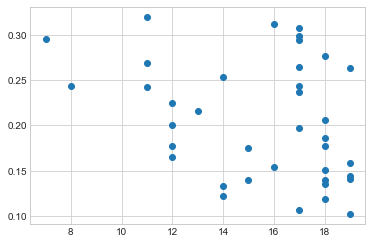

In [31]:
plt.scatter(x,rel_err)
plt.show()

In [21]:
wls_high_stat = smf.wls("log_conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df_filt, weights=df_filt['bin']).fit()
print(wls_high_stat.summary())


                            WLS Regression Results                            
Dep. Variable:          log_conv_rate   R-squared:                       0.821
Model:                            WLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     41.60
Date:                Tue, 05 Jan 2021   Prob (F-statistic):          1.06e-217
Time:                        15:53:51   Log-Likelihood:                -689.65
No. Observations:                 795   AIC:                             1539.
Df Residuals:                     715   BIC:                             1914.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [22]:
wls_high_stat_del = smf.wls("log_conv_rate ~ log_price + delivery_weeks + C(item_code)", df_filt, weights=df_filt['bin']).fit()
print(wls_high_stat_del.summary())



                            WLS Regression Results                            
Dep. Variable:          log_conv_rate   R-squared:                       0.787
Model:                            WLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     33.53
Date:                Tue, 05 Jan 2021   Prob (F-statistic):          1.91e-191
Time:                        15:53:51   Log-Likelihood:                -758.67
No. Observations:                 795   AIC:                             1677.
Df Residuals:                     715   BIC:                             2052.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [23]:
#wls_model_with_fe = smf.wls("log_sales ~ log_price + log_delivery_weeks + log_avg_unique_views + C(item_code)", df, weights=df['bin']).fit()
#print(wls_model_with_fe.summary())


In [24]:
#wls_model_with_fe_all_in = smf.wls("log_sales ~ log_price + log_delivery_weeks + log_avg_unique_views + log_conv_rate +  C(item_code)", df, weights=df['bin']).fit()
#print(wls_model_with_fe_all_in.summary())



In [25]:
#WLS CV rate vs the rest
wls_cr_with_fe = smf.wls("log_conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df, weights=df['bin']).fit()
print(wls_cr_with_fe.summary())


                            WLS Regression Results                            
Dep. Variable:          log_conv_rate   R-squared:                       0.631
Model:                            WLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     82.56
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:53:51   Log-Likelihood:                -6828.7
No. Observations:                4592   AIC:                         1.385e+04
Df Residuals:                    4498   BIC:                         1.445e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [26]:
def run_model(item_code, df):
    print(f'Running model for the item_code {item_code}')
    wls_cr_with_fe = smf.wls("conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df, weights=df['bin']).fit()
    print(wls_cr_with_fe.summary())
    beta_log_price, beta_std_err_log_price = wls_cr_with_fe.params[-2].round(4),wls_cr_with_fe.bse[-2].round(4)
    beta_log_del, beta_std_err_log_del = wls_cr_with_fe.params[-1].round(4),wls_cr_with_fe.bse[-1].round(4)
    Result_log_price = 'Log_price  = ' + str(beta_log_price) + ' ± ' + str(beta_std_err_log_price)
    Result_log_del = 'Log_del_week = ' + str(beta_log_del) + ' ± ' + str(beta_std_err_log_del)



In [27]:
end_date = pd.to_datetime('2020-11-10').date()
df_before_BF = df[df['max_date'] <= end_date]
df_before_BF

,min_date,max_date,item_code,item_price,delivery_weeks,avg_sales,avg_unique_views,conv_rate,bin,item_parent_item_code,item_main_category,item_sub_category_1,item_sub_category_2,log_price,log_delivery_weeks,log_sales,log_avg_unique_views,log_conv_rate
0,2020-01-01,2020-01-07,000000001000054998,749.99,2,1.428571,72.857143,0.019608,7,000000008000006211,POLSTER,ECKSOFAS,LONGCHAIR,6.620060,0.693197,0.356745,4.288502,-3.926739
1,2020-01-01,2020-01-22,000000001000091265,599.99,1,1.818182,61.818182,0.029412,22,000000008000009860,MATRATZEN&LATTENROSTE,MATRATZEN,KALTSCHAUMMATRATZEN,6.396913,0.000100,0.597892,4.124199,-3.522966
2,2020-01-01,2020-01-02,000000001000021540,1449.99,2,1.500000,323.500000,0.004637,2,000000008000001826,POLSTER,WOHNLANDSCHAFTEN,WOHNLANDSCHAFTEN,7.279312,0.693197,0.405532,5.779199,-5.352397
3,2020-01-01,2020-01-07,000000001000054984,749.99,2,2.142857,152.142857,0.014085,7,000000008000006211,POLSTER,ECKSOFAS,LONGCHAIR,6.620060,0.693197,0.762187,5.024821,-4.255605
4,2020-01-01,2020-01-07,000000001000054946,1099.99,2,3.000000,275.000000,0.010909,7,000000008000006213,POLSTER,WOHNLANDSCHAFTEN,WOHNLANDSCHAFTEN,7.003056,0.693197,1.098646,5.616771,-4.509034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4040,2020-11-10,2020-11-10,000000001000008546,249.99,2,13.000000,429.000000,0.030303,1,000000001000008546-P,BÜRO,SCHREIBTISCHE,GERADE SCHREIBTISCHE,5.521421,0.693197,2.564957,6.061457,-3.493213
4041,2020-11-10,2020-11-10,000000001000062032,1549.99,3,3.000000,240.000000,0.012500,1,000000008000006759,BETTEN,BOXSPRINGBETTEN,BOXSPRINGBETTEN,7.346004,1.098646,1.098646,5.480639,-4.374058
4043,2020-11-10,2020-11-10,000000001000062061,1649.99,7,2.000000,185.000000,0.010811,1,000000008000006759,BETTEN,BOXSPRINGBETTEN,BOXSPRINGBETTEN,7.408525,1.945924,0.693197,5.220356,-4.518001
4045,2020-11-10,2020-11-10,000000001000021703,749.99,5,8.000000,269.000000,0.029740,1,000000008000001862,POLSTER,ECKSOFAS,OTTOMANE,6.620060,1.609458,2.079454,5.594712,-3.511913


In [28]:
wls_cr_del_w_with_fe_before_BF = smf.wls("log_conv_rate ~ log_price + log_delivery_weeks + C(item_code)", df_before_BF, weights=df_before_BF['bin']).fit()
print(wls_cr_del_w_with_fe_before_BF.summary())


                            WLS Regression Results                            
Dep. Variable:          log_conv_rate   R-squared:                       0.641
Model:                            WLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     74.47
Date:                Tue, 05 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:53:51   Log-Likelihood:                -5884.5
No. Observations:                3976   AIC:                         1.196e+04
Df Residuals:                    3882   BIC:                         1.255e+04
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

<AxesSubplot:xlabel='log_price'>

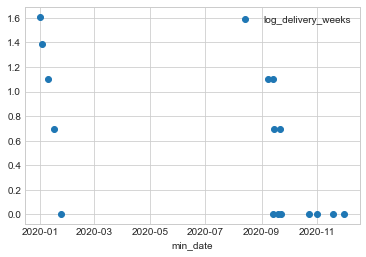

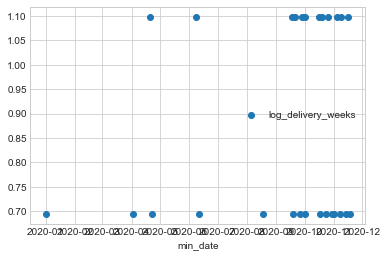

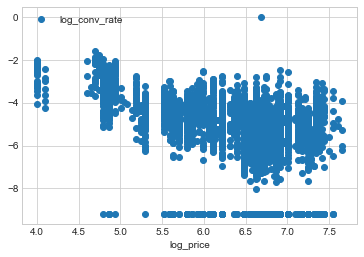

In [29]:
df[df['item_code']== '000000001000016019'].plot(x='min_date',y='log_delivery_weeks', style = 'o')
df[df['item_code']== '000000001000022573'].plot(x='min_date',y='log_delivery_weeks', style = 'o')
df_before_BF.plot(x='log_price',y='log_conv_rate', style = 'o')